# Phenopacket store statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 

The input file is the zip file that is or will be added to each release.

In [1]:
from ppktstore.stats import PPKtStoreStats
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
stats = PPKtStoreStats(input_zipfile="all_phenopackets.zip")

Extracted 4417 phenoapckets in 146 cohorts.


In [3]:
df = stats.get_df()
df.head(2)

,disease,disease_id,patient_id,gene,allele_1,allele_2,PMID
0,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual KCHYD24-1,ESAM,NM_138961.3:c.605T>G,,PMID:36996813
1,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual 1,ESAM,NM_138961.3:c.115del,,PMID:36996813


In [4]:
stats_d = stats.get_descriptive_stats()
items = list()
for k,v in stats_d.items():
    items.append({"item": k, "value": v})
df = pd.DataFrame(items)
df.head(30)

Got 2891 unique HPOs


,item,value
0,phenopackets,4417
1,diseases,396
2,genes,358
3,alleles,2340
4,PMIDs,673
5,individuals per disease (max),464
6,individuals per disease (min),1
7,individuals per disease (mean),11.15404
8,individuals per disease (median),1.0
9,individuals per disease (n>=10),94


# Display distribution of counts of phenopackets per disease

In [5]:
counts_per_disease = stats.get_counts_per_disease_df()
counts_per_disease.head(2)

,disease,count
0,OMIM:620371,14
1,OMIM:150250,3


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_with_max(
        disease_counts: pd.Series,
        max_val: int,
        ax=None,
        ):
    assert isinstance(max_val, int) and max_val > 0, '`max_val` must be a positive `int`'

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4), dpi=300)

    bins = list(range(max_val + 1)) + [disease_counts.max() + 1]
    labels = list(map(str, bins[:-2])) + [f'  ≥{max_val}']
    cats = pd.cut(
        x=disease_counts,
        bins=bins,
        labels=labels,
        right=False,
    )
    cat_count = cats.value_counts().sort_index()
    ax.bar(x=cat_count.index, height=cat_count.values)
    ax.set(
        xlabel='Number of cases',
        ylabel='Disease count',
    )
    ax.grid(axis='y')


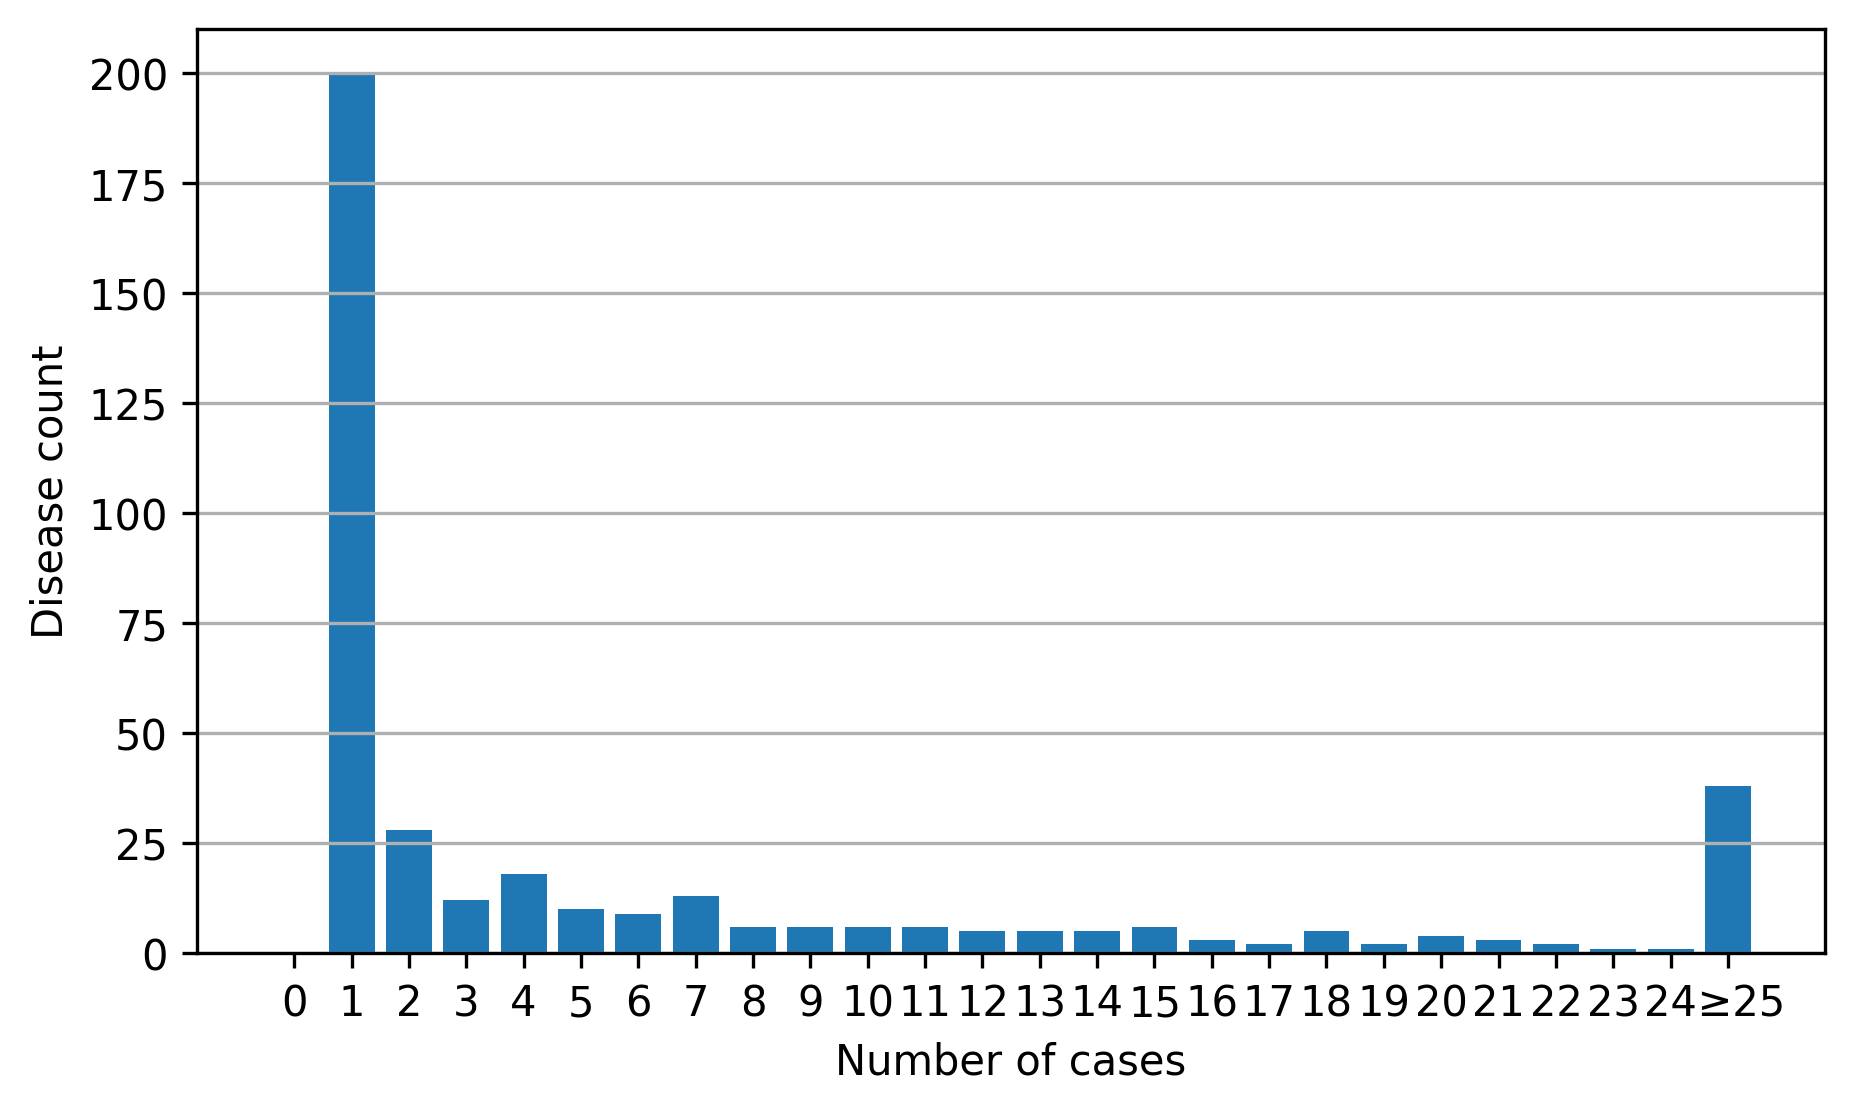

In [7]:
plot_with_max(
    disease_counts=counts_per_disease["count"],
    max_val=25,
)
plt.savefig('counts_per_disease.png')

# Check all disease identifiers
They should all be CURIEs with the prefixes OMIM or MONDO. There should be no whitespace between the colon and the suffix.

In [8]:
df = stats.check_disease_id()

No problems found.


# Count diseases in cohort
In phenopacket-store, each of the folders underneath the "notebooks" folder is counted as a cohort. The following function can be used to 
display the count of diseases in a specific cohort. The intended use case is that in time we would like to move the LIRICAL phenopackets into gene-specific cohorts.

In [9]:
input_zipfile = "all_phenopackets.zip"
target = "LIRICAL"
df = stats.count_diseases_in_cohort(input_zipfile=input_zipfile, cohort=target)
df.head(50)

,label,count
disease_id,,
OMIM:616907,"Spastic paraplegia 76, autosomal recessive",12
OMIM:617425,Immunoskeletal dysplasia with neurodevelopmental abnormalities,10
OMIM:159550,Ataxia-pancytopenia syndrome,10
OMIM:616878,"Metabolic encephalomyopathic crises, recurrent, with rhabdomyolysis, cardiac arrhythmias, and neurodegeneration",6
OMIM:616829,"Congenital disorder of glycosylation, type IIp",6
OMIM:616840,"Parkinson disease 23, autosomal recessive, early onset",4
OMIM:617516,Stankiewicz-Isidor syndrome,4
OMIM:250410,Retinitis pigmentosa with or without skeletal anomalies,4
OMIM:613454,"RETT SYNDROME, CONGENITAL VARIANT",4


# Check for duplicates
In some cases, duplicate phenopackets were inadvertently added to some of the initial cohorts at earlier stages of the project. This function lists phenopacket identifers arranged according to variant and allows us to more easily check for this kind of error.

In [10]:
df = stats.show_possible_duplicates_by_variant(input_zipfile, "ERI1")

No candidate duplicates found for ERI1


# Quality control
The following commands perform several consistency checks.

In [11]:
df = stats.find_phenopackets_with_no_variants(input_zipfile=input_zipfile)

All phenopackets had at least one variant


In [12]:
stats.show_possible_duplicates_by_variant(input_zipfile, "ARPC5")

No candidate duplicates found for ARPC5


""


In [13]:
stats.find_phenopackets_with_no_disease(input_zipfile)

All phenopackets had a disease diagnosis


""


In [14]:
d2p_d = stats._get_disease_to_gene_count_d()

AttributeError: 'PPKtStoreStats' object has no attribute '_get_disease_to_gene_count_d'

In [ ]:
for k,v in d2p_d.items():
    print(k,v)